## Attacking MNIST Dataset

Here we use a custom NN trained on MNIST data to perform *zero order Stochastic Gradient Descent*

**1. Set current directory**

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
cd /content/gdrive/My Drive/Colab Notebooks/AdvAttack

/content/gdrive/My Drive/Colab Notebooks/AdvAttack


In [0]:
import src.loss as customLoss
import src.dataset as data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import math


import torch
from src.models import MnistNet
from torchvision import transforms
from torch import nn, optim

In [0]:
class ZOOptimizer(object):
    """
    Args:
    Name            Type                Description
    model:          (nn.Module)         The model to use to get the output
    loss:           (nn.Module)         The loss to minimize
    device:
    """
    def __init__(self, model, loss, device='cpu'):
        self.device = torch.device(device)
        self.loss = loss
        self.model = model.to(self.device)
        self.model.eval()


    """
    Perform a zero-order optimization
    """
    def run(self, x, c, learning_rate=0.001, batch_size=128,
            h=0.0001, beta_1=0.9, beta_2=0.999, solver="adam", hierarchical=False,
            importance_sampling=False, reset_adam_state=False, verbose=False,
            max_iterations=10000, stop_criterion=1e-10, epsilon=1e-8,
            tqdm_disable=False, additional_out=False):
        """
        Args:
        Name                    Type                Description
        x:                      (torch.tensor)      The variable of our optimization problem- Should be a 3D tensor (img)
        c:                      (float)             Regularization parameter
        learning_rate:          (float)             Learning rate
        maximize:               (bool)              True if the attack is targeted, False otherwise
        batch_size:             (int)               Coordinates we simultaneously optimize
        h:                      (float)             Used in gradient approximation (decrease to increase estimation accuracy)
        beta_1:                 (float)             ADAM hyper-parameter
        beta_2:                 (float)             ADAM hyper-parameter
        solver:                 (string)            ADAM or Newton
        hierarchical:           (bool)              If True use hierarchical attack
        importance_sampling:    (bool)              If True use importance sampling
        reset_adam_state:       (bool)              If True reset ADAM state after a valid attack is found
        epsilon:                (float)             The upper bound of the infinity norm
        max_iterations:         (int)               The maximum number of steps
        stop_criterion          (float)             The minimum loss function
        verbose:                (int)               Display information or not. Default is 0
        tqdm_disable            (bool)              Disable the tqdm bar. Default is False
        """

        # Verify Solver is implemented
        if solver.lower() not in ["adam", "newton"]:
            raise NotImplementedError("Unknown solver, use 'adam' or 'newton'")

        self.c = c
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.solver = solver.lower()
        self.h = h
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.verbose = verbose
        self.epsilon = epsilon
        # Extension
        self.hierarchical = hierarchical
        self.importance_sampling = importance_sampling
        self.reset_adam_state = reset_adam_state

        # Dimension
        self.total_dim = int(np.prod(x.shape))
        self.dim = x.shape
        # Reshape to column vector
        x = x.reshape(-1, 1)
        # Store original image
        x_0 = x.clone().detach()

        # Init list of losses, distances and outputs for results
        losses, l2_dist, outs = [], [], []

        # Set ADAM parameters
        if self.solver == "adam":
            self.M = torch.zeros(x.shape).to(self.device)
            self.v = torch.zeros(x.shape).to(self.device)
            self.T = torch.zeros(x.shape).to(self.device)

        # Main Iteration
        for iteration in tqdm(range(max_iterations), disable=tqdm_disable):

            # Call the step
            x, g = self.step(x)

            # Compute new loss
            out = self.model(x.view(1, self.dim[0], self.dim[1], self.dim[2]))
            loss = self.loss(out)
            l2 = torch.norm(x-x_0).detach()

            # Save results
            outs.append(float(out.detach().cpu()[0, self.loss.neuron].item()))
            losses.append(float(loss.detach().cpu().item()))
            l2_dist.append(l2)

            # Display current info
            if verbose:
                print('---------------------------')
                print('Shape of x: {}'.format(x.shape))
                print('x:  {}'.format(x))
                print('New loss:    {}'.format(loss.cpu().item()))
                print('L2 distance: {}'.format(l2))

            # Evaluate stop criterion

        # Return
        x = x.reshape(self.dim[0], self.dim[1], self.dim[2])
        if additional_out:
            return x, losses, l2_dist, outs
        return x, losses, outs


    """
    Do an optimization step
    """
    def step(self, x):

        # 1. Randomly pick batch_size coordinates
        if self.batch_size > self.total_dim:
            raise ValueError("Batch size must be lower than the total dimension")
        indices = np.random.choice(self.total_dim, self.batch_size, replace=False)  # return np.ndarray(n_batches)
        e_matrix = torch.zeros(self.batch_size, self.total_dim).to(self.device)
        for n, i in enumerate(indices):
            e_matrix[n, i] = 1
        x_expanded = x.view(-1).expand(self.batch_size, self.total_dim).to(self.device)

        # 2. Call verbose
        if self.verbose:
            print('INPUT')
            print('The input x has shape:\t\t{}'.format(x.shape))
            print('Chosen indices are: {}\n'.format(indices))

        # 3. Optimizers
        if self.solver == "adam":
            # Gradient approximation
            g_hat = self.compute_gradient(x_expanded, e_matrix).view(-1, 1)
            # Update
            self.T[indices] = self.T[indices] + 1
            self.M[indices] = self.beta_1 * self.M[indices] + (1 - self.beta_1) * g_hat
            self.v[indices] = self.beta_2 * self.v[indices] + (1 - self.beta_2) * g_hat**2
            M_hat = torch.zeros_like(self.M).to(self.device)
            v_hat = torch.zeros_like(self.v).to(self.device)
            M_hat[indices] = self.M[indices] / (1 - self.beta_1 ** self.T[indices])
            v_hat[indices] = self.v[indices] / (1 - self.beta_2 ** self.T[indices])
            delta = -self.learning_rate * (M_hat / (torch.sqrt(v_hat) + self.epsilon))
            # Remove constraints
            x = (x-x.mean())/(x.std())
            x = x + delta.view(-1, 1)
            x = x*x.std()+x.mean()

        elif self.solver == "newton":
            # Gradient and Hessian approximation
            g_hat, h_hat = self.compute_gradient(x_expanded, e_matrix)
            # TODO

        # 4. Call verbose
        if self.verbose:
            print('OUTPUT')
            print('g_hat has shape {}'.format(g_hat.shape))
            print('g_hat ='.format(g_hat))

        # 5. Return
        return x.detach(), g_hat.detach()


    """
    Compute Gradient and Hessian
    """
    def compute_gradient(self, x_expanded, e_matrix):
        # Intermediate steps
        """
        Args:
            x_expanded: matrix (n_pixels, n_batches) containing n_batches times the original image
            e_matrix: matrix (n_pixels, n_batches)
        """
        first_input = x_expanded + self.h*e_matrix
        second_input = x_expanded - self.h * e_matrix
        first_input_scaled = first_input
        second_input_scaled = second_input
        first_out = self.model(first_input_scaled.view(self.batch_size, *list(self.dim)))
        second_out = self.model(second_input_scaled.view(self.batch_size, *list(self.dim)))
        first_term = self.loss(first_out)
        second_term = self.loss(second_out)

        # Compute gradient
        g_hat = (first_term - second_term)/2*self.h

        # Compute hessian
        if self.solver == "newton":
            h_hat = (first_term + second_term - 2*self.loss(x_expanded))/self.h**2
            return g_hat.detach(), h_hat.detach()
        return g_hat.detach()




**2. Import libraries**

**3. Retrieve MNIST data**

We retrieve the MNIST data. <br>
The 'standard' *trasnform.compose* method just convert the data to *torch.Tensor* without any rescaling or normalizzation


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


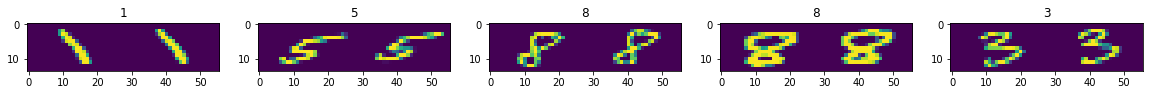

In [13]:
DataLoader = data.MNIST(transform='standard')
train, test = DataLoader.get_dataloader(batch_size=250, num_workers=0)
DataLoader.get_info()

**4. Retrieve the network**

In [14]:
device = torch.device('cuda')
net = MnistNet().to(device)
net.load_state_dict(torch.load('models/mnistBaseV2_state_dict.pth'))

<All keys matched successfully>

### MAIN
**5. ADVERSARIAL ATTACK**

Here we try to start with a random rightfully classified image from the validation set and we try to use *Zero-order Stochastic Conditional Gradient* to modify the image in order to make the network be mistaken.

We can set an epsilon as an upper bound for the inifinity norm of our input.

**Args:**

        Name            Type                Description
        
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        v:              (float)             The gaussian smoothing
        mk:             (list)              Number of normal vector to generate at every step
        ak              (list)              Pseudo learning rate/momentum  every step
        epsilon:        (float)             The upper bound of the infinity norm
        C:              (tuple)             The boundaries of the pixel. Default is (0, 1)
        max_steps:      (int)               The maximum number of steps. Default is 100
        verbose:        (int)               Display information or not. Default is 0
        additional_out  (bool)              Return also all the x. Default is False
        tqdm_disable    (bool)              Disable the tqdm bar. Default is False

**Suggested values** <br>
*Zeroth-order Nonconvex Stochastic Optimization: Handling Constraints, High-Dimensionality and Saddle-Points* (rishnakumar Balasubramanian†1 and Saeed Ghadimi‡2):

$v = \sqrt{\frac{2B_{L_{\sigma}}}{N(d+3)^3}}$, 
$\alpha_{k} =\frac{1}{\sqrt{N}}$,
$m_{k} = 2B_{L_{\sigma}}(d + 5)N$,
$\forall k \geq 1$

where:<br>
- *N* is the number of steps <br>
- *d* is the dimension of *x* <br>
- $B_{L_{\sigma}} ≥ max\bigg\{\sqrt{\frac{B^2 + \sigma^2}{L}}, 1\bigg\}$

**E.G:** <br>
If we set $N = 100$, $B_{L_{\sigma}} = 1$ and we have a image 28 * 28 ($d = 784$) we have: <br>

- $v = 10e-6$
- $\alpha_{k} = 0.1$
- $m_{k} = 15780$

**N.B** <br>
In reality it seems that $\alpha_{k}$ could be set much higher (e.g. 0.5)  and $m_{k}$ could be set much lower (e.g. 600)  

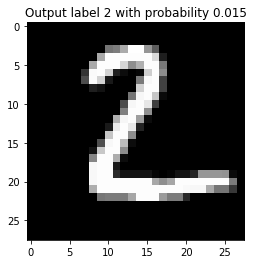

In [80]:
### Get an input used as test
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)
    break

net.eval()
img_orig = X[1].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[1].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out[0, original_label])))
plt.show()

**5.1 Specific attack**

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

*E.g.* <br> 
We want to try to maximise the probability of classification of neuron *eight*



  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 6/200 [00:00<00:03, 59.90it/s]

  6%|▌         | 12/200 [00:00<00:03, 57.90it/s]

  9%|▉         | 18/200 [00:00<00:03, 58.39it/s]

 12%|█▏        | 24/200 [00:00<00:03, 58.32it/s]

 15%|█▌        | 30/200 [00:00<00:02, 58.11it/s]

 18%|█▊        | 36/200 [00:00<00:02, 57.65it/s]

 21%|██        | 42/200 [00:00<00:02, 58.03it/s]

 24%|██▍       | 48/200 [00:00<00:02, 55.41it/s]

 27%|██▋       | 54/200 [00:00<00:02, 55.60it/s]

 30%|███       | 60/200 [00:01<00:02, 55.95it/s]

 33%|███▎      | 66/200 [00:01<00:02, 56.15it/s]

 36%|███▌      | 72/200 [00:01<00:02, 56.70it/s]

 40%|███▉      | 79/200 [00:01<00:02, 57.86it/s]

 42%|████▎     | 85/200 [00:01<00:02, 56.59it/s]

 46%|████▌     | 91/200 [00:01<00:01, 57.44it/s]

 48%|████▊     | 97/200 [00:01<00:01, 57.86it/s]

 52%|█████▏    | 103/200 [00:01<00:01, 57.56it/s]

 55%|█████▍    | 109/200 [00:01<00:01, 57.09it/s]

 57%|█████▊    | 115/200 [00:02<00:01, 56.46it/s]

 60%|

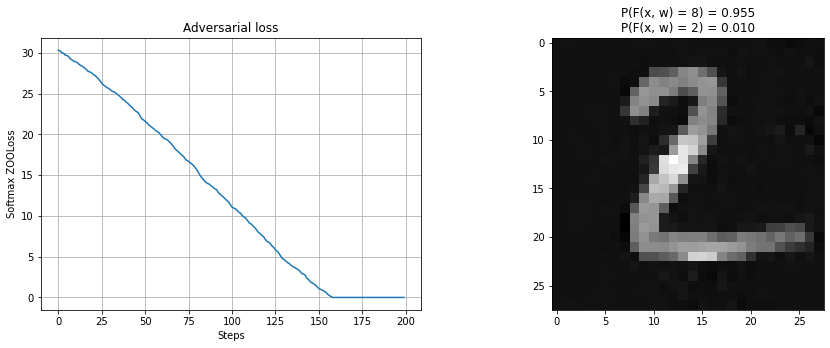

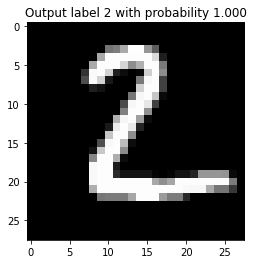

In [82]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=8, maximise=1)
adv_optimizer = ZOOptimizer(model=net, loss=adv_loss, device='cuda')
### Run the optimizer
x, loss, outs = adv_optimizer.run(X[1]*0.8+0.1, 
                                  c               =  0.4,
                                  learning_rate = 0.1,
                                  verbose         =  0,
                                  max_iterations = 200,
                                  additional_out  =  False)

### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('Softmax ZOOLoss')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]),
                                                                             original_label, float(out[0, original_label])))
plt.show()

plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig)
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

In [48]:
outs


[0.6727234125137329,
 0.6089385747909546,
 0.6040558815002441,
 0.6028982400894165,
 0.6026664972305298,
 0.6026155352592468,
 0.6026068329811096,
 0.6026053428649902,
 0.6026033759117126,
 0.6026028394699097,
 0.602603554725647,
 0.6026034951210022,
 0.6026037931442261,
 0.602603554725647,
 0.6026034951210022,
 0.6026036739349365,
 0.6026036739349365,
 0.602603554725647,
 0.602603554725647,
 0.6026037931442261]

**5.2 General attack**

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

*E.g.* <br> 
We want to try to manimize the probability of classification of neuron *zero*

  0%|▍                                                                                 | 2/400 [00:00<01:09,  5.73it/s]


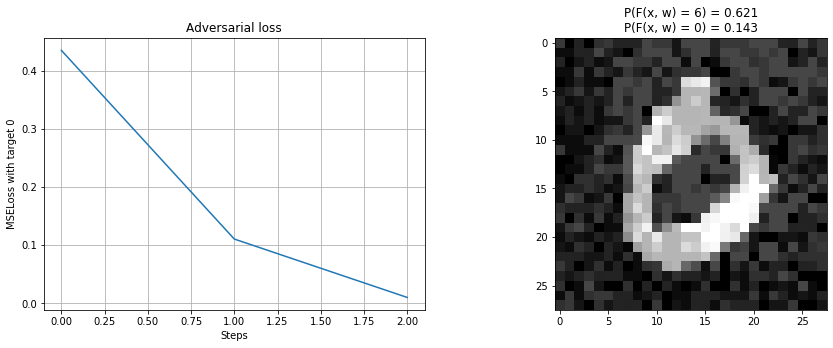

In [0]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.MSELoss(neuron=0, maximise=0, is_softmax=False, dim=1)
adv_optimizer = zeroOptim.ClassicZSCG(net, adv_loss, 'cuda')
### Run the optimizer
EPOCH = 400
x, loss, outs = adv_optimizer.run(X[3], 
                                  v               =  0.0001, 
                                  mk              =  [28**2]*EPOCH, 
                                  ak              =  [0.4]*EPOCH,
                                  epsilon         =  0.35, 
                                  max_steps       =  EPOCH, 
                                  verbose         =  0, 
                                  additional_out  =  False)
### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('MSELoss with target 0')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]), 
                                                                             original_label, float(out[0, original_label])))
plt.show()

**Success rate at different infinity norm upper bound**

Here we can see how the algorithm perform when it goes from stricter to less strict epsilon with the first 10 validation images.

**BETTER ON COLAB**

In [0]:
device = torch.device('cuda')
EPOCH = 100
def evaluate(e, n=7, mk=28**2, ak=0.8, v=0.2):
    X_test = X[:n, ...]
    success = []
    xs = []
    for x in tqdm(X_test):
        y_before = int(torch.argmax(net(x.to(device).view(1, 1, 28, 28))))
        loss = customLoss.MSELoss(neuron=y_before, maximise=0, dim=1)
        ADVoptim = zeroOptim.ClassicZSCG(model=net, loss=loss, device=device)
        x_out, loss_curve, out =  ADVoptim.run(x, 
                                               v=v, 
                                               mk=[mk]*EPOCH, 
                                               ak=[ak]*EPOCH,
                                               epsilon=e, 
                                               max_steps=EPOCH, 
                                               verbose=0,
                                               tqdm_disabled=True)

        if int(torch.argmax(net(x_out.reshape(1, 1, 28, 28))).item()) != y_before:
            success.append(1)
        else:
            success.append(0)
        xs.append(x_out)
    return success, xs

net = net.to(device)
epsilon = 0.25
success_list, out_list = evaluate(epsilon, ak=0.9)
print('Success rate with epsilon = {}:\t{:.1f}%'.format(epsilon, 100*np.sum(success_list)/len(success_list)))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:18<00:00,  2.70s/it]

Success rate with epsilon = 0.25:	57.1%


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.87it/s]


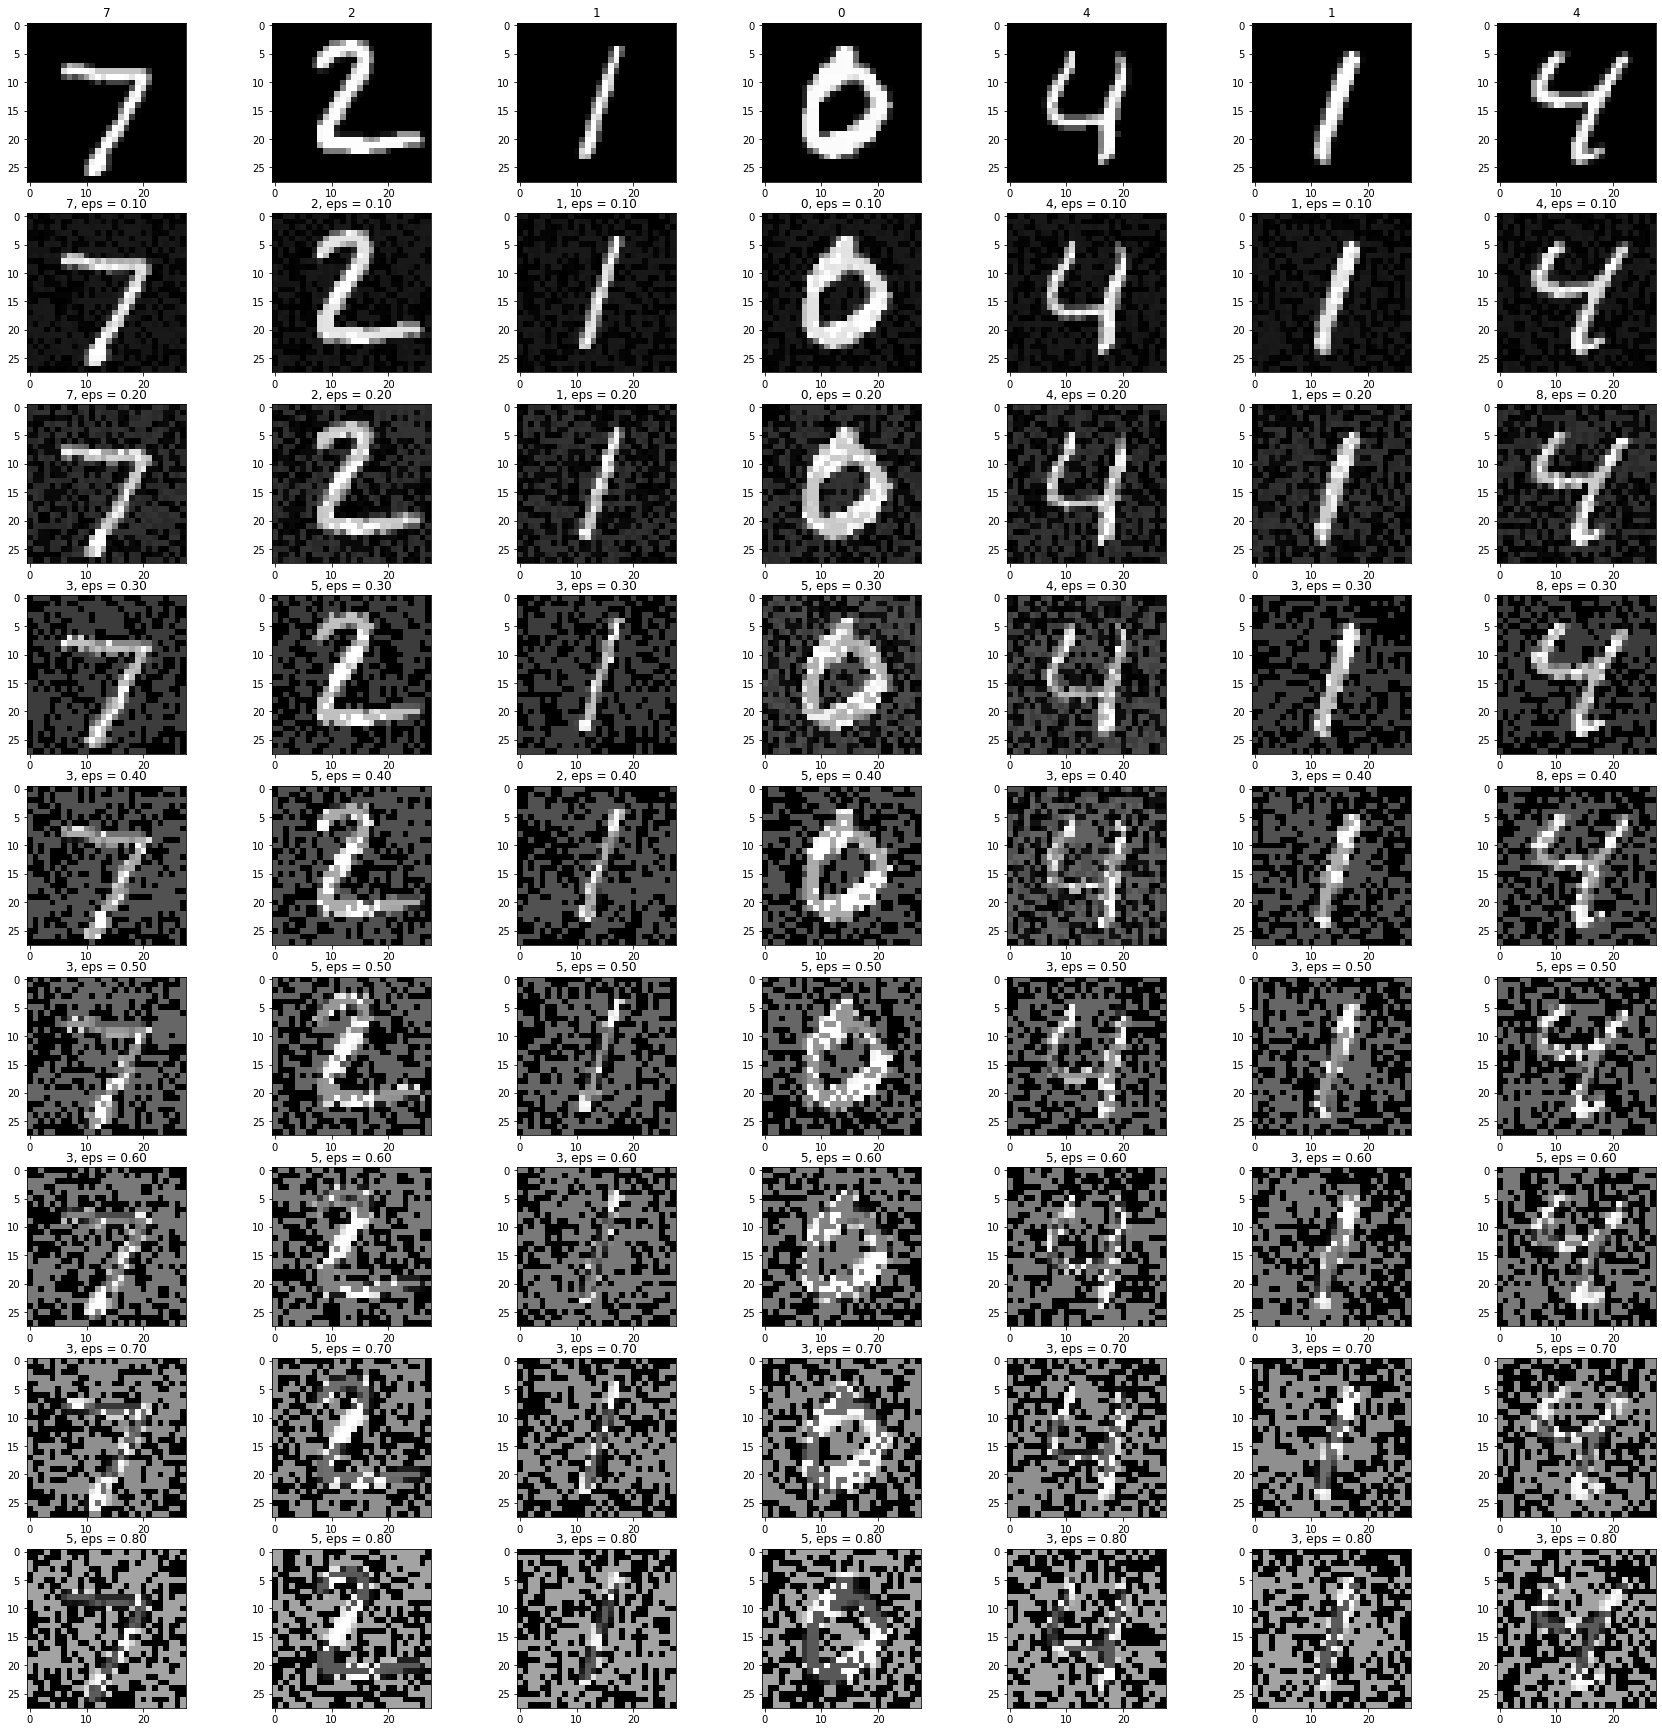

In [0]:
fig, ax = plt.subplots(9, 7, figsize = (30, 31))
for n in range(7):
    out_before = int(torch.argmax(net(X[n, ...].to(device).view(1, 1, 28, 28))))
    img_before = X[n, ...].detach().cpu().numpy()
    ax[0, n].imshow(img_before.reshape(28, 28), cmap='gray')
    ax[0, n].set_title(out_before)
for i in range(1, 9):
    a1, b1 = evaluate(0.1*i)
    for n, t in enumerate(zip(a1, b1)):
        out_after = int(torch.argmax(net(t[1].view(1, 1, 28, 28))))
        img_after = t[1].detach().cpu().numpy()
        ax[i, n].imshow(img_after.reshape(28, 28), cmap='gray')
        ax[i, n].set_title('{}, eps = {:.2f}'.format(out_after, float(i*0.1)))
plt.show()